In [1]:
import sys
sys.path.append("..")

from plotting_tools import * 

In [2]:
def load_simulation_data(sim_results):
    # Read simulation output
    df = pd.read_csv(sim_results, sep=',')
    df = df.drop(['NumAgents'], axis=1)
    df = df.rename(columns={"t": "LocType", "AgeGroup": "NumAgents", "locType": "AgeGroup"})
    return df

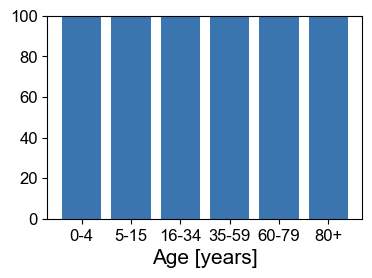

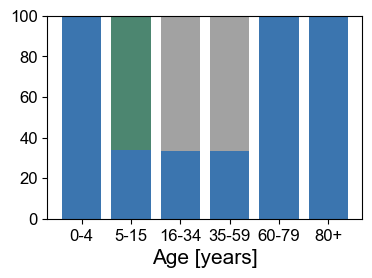

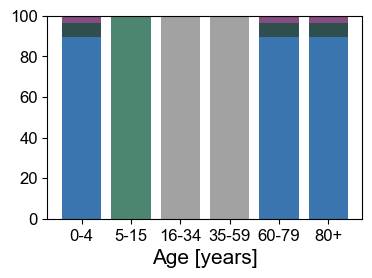

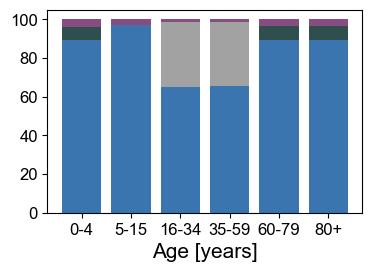

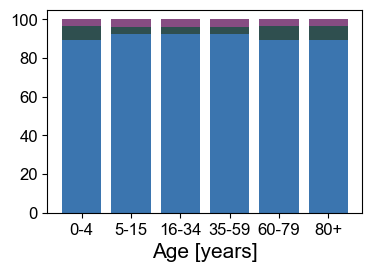

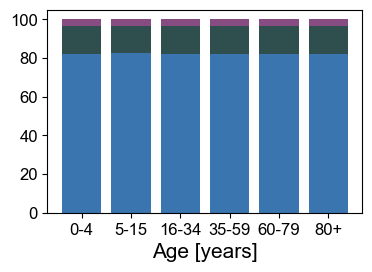

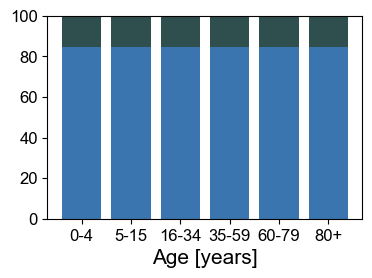

<Figure size 840x290 with 0 Axes>

In [ ]:
loctype_results = 'OnlyMovement/0_num_agents_loc_type_ag.txt'
time_points = [get_time_point(0, 0), get_time_point(0, 8), get_time_point(0, 12), get_time_point(0, 17), get_time_point(0, 20), get_time_point(5, 14), get_time_point(6, 14)]
timepoint_names = ['Mo 12am', 'Mo 8am', 'Mo 12pm', 'Mo 17pm', 'Mo 20pm', 'Sa 14pm', 'So 14pm']
df = load_simulation_data(loctype_results)

figsize = (4.2, 2.9)
panel_pos = [0.21, 0.2, 0.75, 0.7] 

# Create one plot per time point
for idx, t in enumerate(time_points):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_axes(panel_pos)
    ax1.set_xlabel('Age [years]')
    x_pos = [i * 1 for i in range(len(age_groups))]
    ax1.set_xticks(x_pos, age_groups)
    # Start values for bars
    bottom1 = np.zeros(len(age_groups))
    bottom2 = np.zeros(len(age_groups))
    # Get subdf for current time point
    output_tp = df[df.index == t]
    sum_per_age_group = [output_tp[(output_tp.AgeGroup == age)].NumAgents.sum() for age in age_groups]
    labels = []
    for type in output_tp.LocType.unique():
        labels.append(idx_to_loctype_dict[type])
        values = [output_tp[(output_tp.LocType == type) & (output_tp.AgeGroup == age)].NumAgents.iloc[0] for age in age_groups]
        percentage = [100 * v / sum_per_age_group[j] for j, v in enumerate(values)]
        ax1.bar(x_pos, percentage, bottom = bottom2, color = [loctype_to_color_dict[idx_to_loctype_dict[type]] for i in range(len(timepoint_names))])
        bottom2 += percentage
    fig.savefig(f'num_agents_per_loctype_bars_{timepoint_names[idx]}.png', dpi=dpi)
    plt.show()

labels = []
for type in output_tp.LocType.unique():
    # Add LocationType label
    labels.append(idx_to_loctype_dict[type])
patchList = []
for key in labels:
        data_key = patches.Patch(color=loctype_to_color_dict[key], label=key)
        patchList.append(data_key)

fig = plt.figure(figsize=(figsize[0]*2, figsize[1]))
legend = fig.legend(handles=patchList, loc='center left', bbox_to_anchor=(0, 0.5), ncol = 5)
plt.tight_layout()
plt.show()
fig.savefig(f'legend_loctypes.png', dpi=dpi)

In [8]:
def get_spatial_pop_dist(ww_shape_file, sim_results):
    # Read wastewater shape file
    ww_df = geopandas.read_file(ww_shape_file)
    # Add column for base values
    ww_df['base'] = 0
    # Add columns for time points
    for t in time_points:
        ww_df[str(t) + "_pos"] = 0
        ww_df[str(t) + "_neg"] = 0
    # Read simulation output    
    output = pd.read_csv(sim_results, sep=',')
    output = output.drop([' NumCommuters'], axis=1)
    output = output.rename(columns={"t": "Area", "Area": "NumAgents", "NumAgents": "NumInhabitants", " NumInhabitants": "NumCommuters"})
    
    # Get base value and relative positive and negative change per ww area and time point    
    for area in ww_df.ID_TAN.unique():
        base_value = output[(output.Area == area) & (output.index == 0)].NumAgents.iloc[0]
        ww_df.loc[ww_df.index[ww_df.ID_TAN == area], 'base'] = base_value
        for t in time_points:
            commuter = output[(output.Area == area) & (output.index == t)].NumCommuters.iloc[0]
            inhabitants = output[(output.Area == area) & (output.index == t)].NumInhabitants.iloc[0]
            ww_df.loc[ww_df.index[ww_df.ID_TAN == area], str(t) + "_pos"] = 100. * abs(float(commuter)) / float(base_value)
            ww_df.loc[ww_df.index[ww_df.ID_TAN == area], str(t) + "_neg"] = 100. * abs(float(inhabitants) - float(base_value)) / float(base_value)
    return ww_df

C:\Users\bick_ju\AppData\Local\Temp\ipykernel_1528\3876290026.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '41.370558375634516' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ww_df.loc[ww_df.index[ww_df.ID_TAN == area], str(t) + "_pos"] = 100. * abs(float(commuter)) / float(base_value)
C:\Users\bick_ju\AppData\Local\Temp\ipykernel_1528\3876290026.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.59390862944162' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ww_df.loc[ww_df.index[ww_df.ID_TAN == area], str(t) + "_neg"] = 100. * abs(float(inhabitants) - float(base_value)) / float(base_value)
C:\Users\bick_ju\AppData\Local\Temp\ipykernel_1528\3876290026.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and 

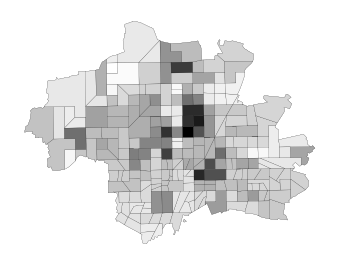

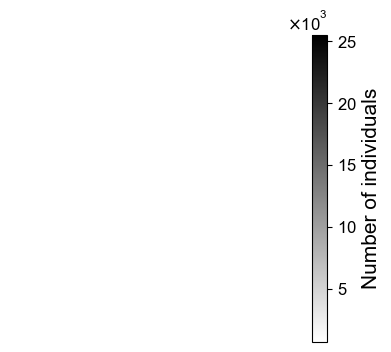

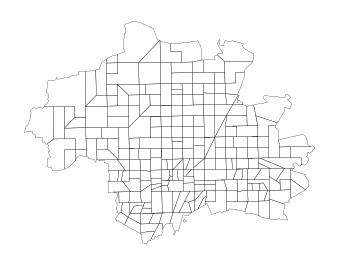

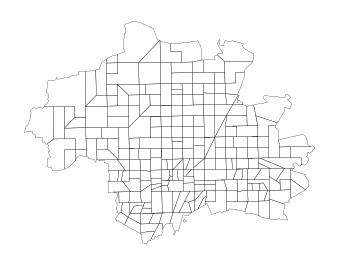

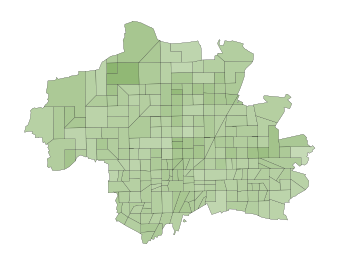

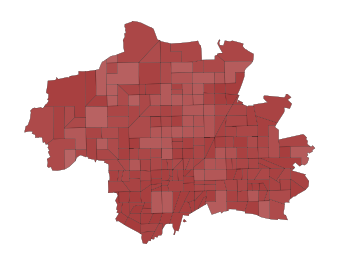

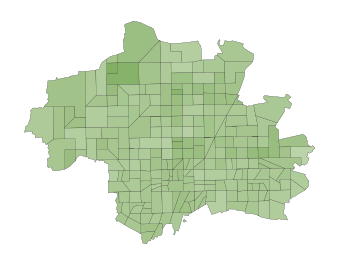

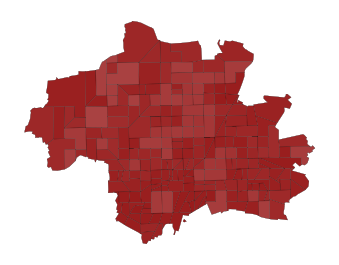

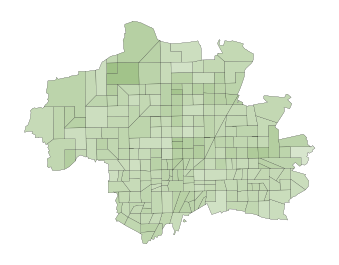

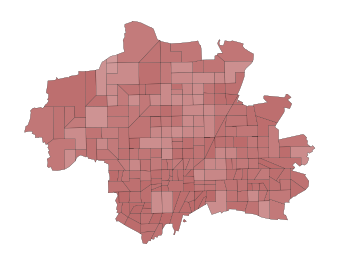

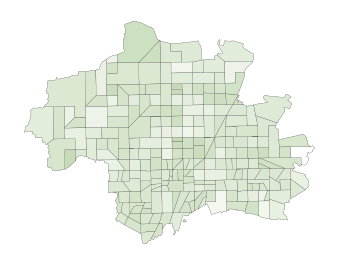

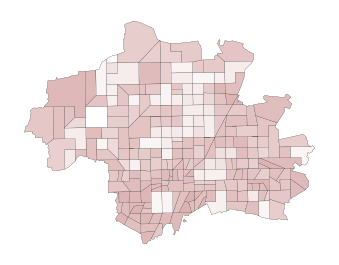

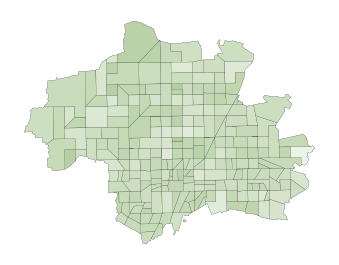

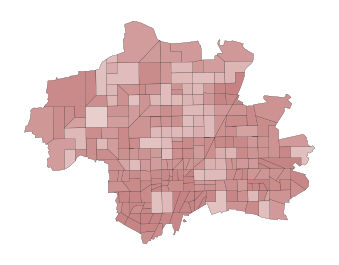

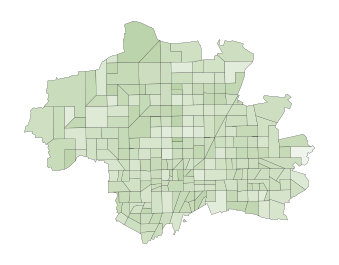

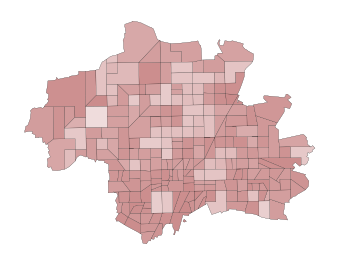

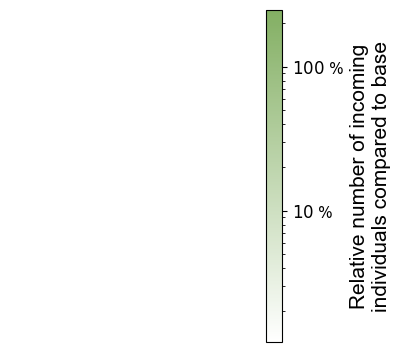

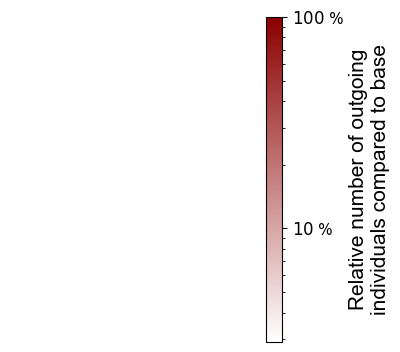

: 

In [ ]:
mobility_result = 'OnlyMovement/0_num_agents_area_inhabitants_commuters.txt'
ww_areas_shp_file = 'Verschnitt_DLR_TAN_Rep.shp'

ww_df = get_spatial_pop_dist(ww_areas_shp_file, mobility_result)

base_cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["white", colors['Black']])
custom_cmap_pos = mcolors.LinearSegmentedColormap.from_list("custom", ["white", colors['Green']])
custom_cmap_neg = mcolors.LinearSegmentedColormap.from_list("custom", ["white", colors['Dark red']])

# Plot base value
fig, ax = plt.subplots(figsize = figsize)
ww_df.plot(ax=ax, edgecolor='black', color='white', linewidth = 0.1, legend=False)
norm = mcolors.Normalize(vmin=ww_df['base'].min(), vmax=ww_df['base'].max())
ww_df[ww_df['base']>0].plot(column='base', ax=ax, cmap = base_cmap, norm=norm, edgecolor='black', linewidth = 0.1, legend=False)
ax.set_axis_off()
plt.tight_layout()
plt.show()
fig.savefig(f'pop_movement_base.png', dpi=dpi)

# Add colorbar
sm = matplotlib.cm.ScalarMappable(cmap=base_cmap, norm=norm)
sm._A = []
# Save cbar in extra figure
fig, ax = plt.subplots(figsize = (figsize[0]/1., figsize[1]*1.3))
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Number of individuals')
ax.set_axis_off()
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((3, 3))
cbar.ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()
fig.savefig(f'pop_movement_base_cbar.png', dpi=dpi)

# Get min and max value for positive and negative colorbar
all_values_pos = ww_df[[f"{str(t)}_pos" for t in time_points]].values.flatten()
all_values_neg = ww_df[[f"{str(t)}_neg" for t in time_points]].values.flatten()
norm_pos = mcolors.LogNorm(vmin=np.min(all_values_pos[np.nonzero(all_values_pos)]), vmax=all_values_pos.max())
norm_neg = mcolors.LogNorm(vmin=np.min(all_values_neg[np.nonzero(all_values_neg)]), vmax=100)
for index, t in enumerate(time_points):
    fig_pos, ax_pos = plt.subplots(figsize = figsize)
    ax_pos.set_xticks([])
    ax_pos.set_yticks([])
    ww_df.plot(ax=ax_pos, edgecolor='black', color='white', linewidth = 0.1, legend=False)
    ww_df.plot(column=f"{str(t)}_pos", ax=ax_pos, cmap = custom_cmap_pos, norm = norm_pos, edgecolor='black', linewidth = 0.1, legend=False)
    ax_pos.set_axis_off()    
    plt.tight_layout()
    plt.show()
    fig_pos.savefig(f'pop_movement_change_{timepoint_names[index]}_pos.png', dpi=dpi)
    fig_neg, ax_neg = plt.subplots(figsize = figsize)
    ax_neg.set_xticks([])
    ax_neg.set_yticks([])
    ww_df.plot(ax=ax_neg, edgecolor='black', color='white', linewidth = 0.1, legend=False)
    ww_df.plot(column=f"{str(t)}_neg", ax=ax_neg, cmap = custom_cmap_neg, norm = norm_neg, edgecolor='black', linewidth = 0.1, legend=False)
    ax_neg.set_axis_off()    
    plt.tight_layout()
    plt.show()
    fig_neg.savefig(f'pop_movement_change_{timepoint_names[index]}_neg.png', dpi=dpi)

# Ticks for both colorbars    
powers = [1, 2]
ticks = [10**p for p in powers]
tick_labels = [f"${tick}$ %" for tick in ticks]
# Plot colorbar for positive values (commuters)
fig, ax = plt.subplots(figsize = (figsize[0]/1, figsize[1]*1.3))
sm = matplotlib.cm.ScalarMappable(cmap=custom_cmap_pos, norm=norm_pos)
sm._A = []
# Create colorbar with explicit ticks
cbar = fig.colorbar(sm, ax=ax)
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label('Relative number of incoming\nindividuals compared to base')
# Reduce linewidth of colorbar
ax.set_axis_off()
plt.tight_layout()
plt.show()
# Save figure
fig.savefig(f'pop_movement_change_cbar_pos.png', dpi=dpi)
# Plot colorbar for negative values (inhabitants)
fig, ax = plt.subplots(figsize = (figsize[0]/1, figsize[1]*1.3))
sm = matplotlib.cm.ScalarMappable(cmap=custom_cmap_neg, norm=norm_neg)
sm._A = []
# Create colorbar with explicit ticks
cbar = fig.colorbar(sm, ax=ax)
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label('Relative number of outgoing\nindividuals compared to base')
ax.set_axis_off()
plt.tight_layout()
plt.show()
# Save figure
fig.savefig(f'pop_movement_change_cbar_neg.png', dpi=dpi)